<a href="https://colab.research.google.com/github/tcano0505/AI_StockFinder_Chatbot/blob/main/Financial_Analysis_%26_Automation_Stock_AI_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries

In [1]:
! pip install yfinance langchain_pinecone openai python-dotenv langchain_community sentence_transformers

In [2]:
!pip install --upgrade openai

In [3]:
from langchain_pinecone import PineconeVectorStore
from openai import OpenAI
import dotenv
import json
import yfinance as yf
import concurrent.futures
from langchain_community.embeddings import HuggingFaceEmbeddings
from google.colab import userdata
from langchain.schema import Document
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone
import numpy as np
import requests
import os

In [4]:
def get_stock_info(symbol: str) -> dict:
    """
    Retrieves and formats detailed information about a stock from Yahoo Finance.

    Args:
        symbol (str): The stock ticker symbol to look up.

    Returns:
        dict: A dictionary containing detailed stock information, including ticker, name,
              business summary, city, state, country, industry, and sector.
    """
    data = yf.Ticker(symbol)
    stock_info = data.info

    properties = {
        "Ticker": stock_info.get('symbol', 'Information not available'),
        'Name': stock_info.get('longName', 'Information not available'),
        'Business Summary': stock_info.get('longBusinessSummary'),
        'City': stock_info.get('city', 'Information not available'),
        'State': stock_info.get('state', 'Information not available'),
        'Country': stock_info.get('country', 'Information not available'),
        'Industry': stock_info.get('industry', 'Information not available'),
        'Sector': stock_info.get('sector', 'Information not available')
    }

    return properties

In [5]:
data = yf.Ticker("NVDA")
stock_info = data.info
print(stock_info)

{'address1': '2788 San Tomas Expressway', 'city': 'Santa Clara', 'state': 'CA', 'zip': '95051', 'country': 'United States', 'phone': '408 486 2000', 'website': 'https://www.nvidia.com', 'industry': 'Semiconductors', 'industryKey': 'semiconductors', 'industryDisp': 'Semiconductors', 'sector': 'Technology', 'sectorKey': 'technology', 'sectorDisp': 'Technology', 'longBusinessSummary': "NVIDIA Corporation provides graphics and compute and networking solutions in the United States, Taiwan, China, Hong Kong, and internationally. The Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gaming platforms; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; virtual GPU or vGPU software for cloud-based visual and virtual computing; automotive platforms for infotainment systems; and Omniverse software for building and operating metaverse and 3D internet applications. The Compute & Networking segment co

In [6]:
def get_huggingface_embeddings(text, model_name="sentence-transformers/all-mpnet-base-v2"):
    """
    Generates embeddings for the given text using a specified Hugging Face model.

    Args:
        text (str): The input text to generate embeddings for.
        model_name (str): The name of the Hugging Face model to use.
                          Defaults to "sentence-transformers/all-mpnet-base-v2".

    Returns:
        np.ndarray: The generated embeddings as a NumPy array.
    """
    model = SentenceTransformer(model_name)
    return model.encode(text)


def cosine_similarity_between_sentences(sentence1, sentence2):
    """
    Calculates the cosine similarity between two sentences.

    Args:
        sentence1 (str): The first sentence for similarity comparison.
        sentence2 (str): The second sentence for similarity comparison.

    Returns:
        float: The cosine similarity score between the two sentences,
               ranging from -1 (completely opposite) to 1 (identical).

    Notes:
        Prints the similarity score to the console in a formatted string.
    """
    # Get embeddings for both sentences
    embedding1 = np.array(get_huggingface_embeddings(sentence1))
    embedding2 = np.array(get_huggingface_embeddings(sentence2))

    # Reshape embeddings for cosine_similarity function
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)

    # Calculate cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)
    similarity_score = similarity[0][0]
    print(f"Cosine similarity between the two sentences: {similarity_score:.4f}")
    return similarity_score


# Example usage
sentence1 = "I like walking to the park"
sentence2 = "I like running to the office"

similarity = cosine_similarity_between_sentences(sentence1, sentence2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Cosine similarity between the two sentences: 0.6133


In [7]:
aapl_info = get_stock_info('AAPL')
print(aapl_info)


{'Ticker': 'AAPL', 'Name': 'Apple Inc.', 'Business Summary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts, as well as advertising services include third-party licensing arrangements and its own advertising platforms. In addition, the company offers various subscription-based services, such as Apple Arcade, a game subscription service; Apple Fitness+, a personalized fitness service; Apple Music, which offers users a curated listening experien

In [8]:
aapl_description = aapl_info['Business Summary']

company_description = "I want to find companies that make smartphones, tablets, watches, and computers are headquarted in California"

similarity = cosine_similarity_between_sentences(aapl_description, company_description)

Cosine similarity between the two sentences: 0.3891


### Get all the stocks in the stock market

Need to get all symbols (tickers) of all stocks in the stock market

In [9]:
def get_company_tickers():
    """
    Downloads and parses the Stock ticker symbols from the GitHub-hosted SEC company tickers JSON file.

    Returns:
        dict: A dictionary containing company tickers and related information.

    Notes:
        The data is sourced from the official SEC website via a GitHub repository:
        https://raw.githubusercontent.com/team-headstart/Financial-Analysis-and-Automation-with-LLMs/main/company_tickers.json
    """
    # URL to fetch the raw JSON file from GitHub
    url = "https://raw.githubusercontent.com/team-headstart/Financial-Analysis-and-Automation-with-LLMs/main/company_tickers.json"

    # Making a GET request to the URL
    response = requests.get(url)

    # Checking if the request was successful
    if response.status_code == 200:
        # Parse the JSON content directly
        company_tickers = json.loads(response.content.decode('utf-8'))

        # Optionally save the content to a local file for future use
        with open("company_tickers.json", "w", encoding="utf-8") as file:
            json.dump(company_tickers, file, indent=4)

        print("File downloaded successfully and saved as 'company_tickers.json'")
        return company_tickers
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
        return None

company_tickers = get_company_tickers()

File downloaded successfully and saved as 'company_tickers.json'


In [10]:
company_tickers

{'0': {'cik_str': 1045810, 'ticker': 'NVDA', 'title': 'NVIDIA CORP'},
 '1': {'cik_str': 320193, 'ticker': 'AAPL', 'title': 'Apple Inc.'},
 '2': {'cik_str': 789019, 'ticker': 'MSFT', 'title': 'MICROSOFT CORP'},
 '3': {'cik_str': 1018724, 'ticker': 'AMZN', 'title': 'AMAZON COM INC'},
 '4': {'cik_str': 1652044, 'ticker': 'GOOGL', 'title': 'Alphabet Inc.'},
 '5': {'cik_str': 1326801, 'ticker': 'META', 'title': 'Meta Platforms, Inc.'},
 '6': {'cik_str': 1318605, 'ticker': 'TSLA', 'title': 'Tesla, Inc.'},
 '7': {'cik_str': 1067983,
  'ticker': 'BRK-B',
  'title': 'BERKSHIRE HATHAWAY INC'},
 '8': {'cik_str': 1046179,
  'ticker': 'TSM',
  'title': 'TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD'},
 '9': {'cik_str': 1730168, 'ticker': 'AVGO', 'title': 'Broadcom Inc.'},
 '10': {'cik_str': 59478, 'ticker': 'LLY', 'title': 'ELI LILLY & Co'},
 '11': {'cik_str': 19617, 'ticker': 'JPM', 'title': 'JPMORGAN CHASE & CO'},
 '12': {'cik_str': 104169, 'ticker': 'WMT', 'title': 'Walmart Inc.'},
 '13': {'cik_str'

In [11]:
len(company_tickers) #Output is the amount of stocks assigned to the company_tickers variable

9998

### Insert Stocks into Pinecone

In [12]:
pinecone_api_key = userdata.get("PINECONE_API_KEY")
os.environ['PINECONE_API_KEY'] = pinecone_api_key

index_name = "stocks"
namespace = "stock-descriptions"

hf_embeddings = HuggingFaceEmbeddings()
vectorstore = PineconeVectorStore(index_name=index_name, embedding=hf_embeddings)

<ipython-input-12-8d5c0f356cf6>:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embeddings = HuggingFaceEmbeddings()
<ipython-input-12-8d5c0f356cf6>:7: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  hf_embeddings = HuggingFaceEmbeddings()


In [13]:
for idx, stock in company_tickers.items():
  stock_ticker = stock['ticker']
  stock_data = get_stock_info(stock_ticker)
  stock_description = stock_data['Business Summary']

  print(f"Processing Stock {idx} / {len(company_tickers)}: ", stock_ticker)

  vectorstore_from_documents = PineconeVectorStore.from_documents(
      documents = [Document(page_content = stock_description, metadata = stock_data)],
      embedding = hf_embeddings,
      index_name = index_name,
      namespace = namespace
  )

Processing Stock 0 / 9998:  NVDA
Processing Stock 1 / 9998:  AAPL
Processing Stock 2 / 9998:  MSFT
Processing Stock 3 / 9998:  AMZN
Processing Stock 4 / 9998:  GOOGL
Processing Stock 5 / 9998:  META


KeyboardInterrupt: 

### Parallelizing

Visual Representation of Sequential Processing

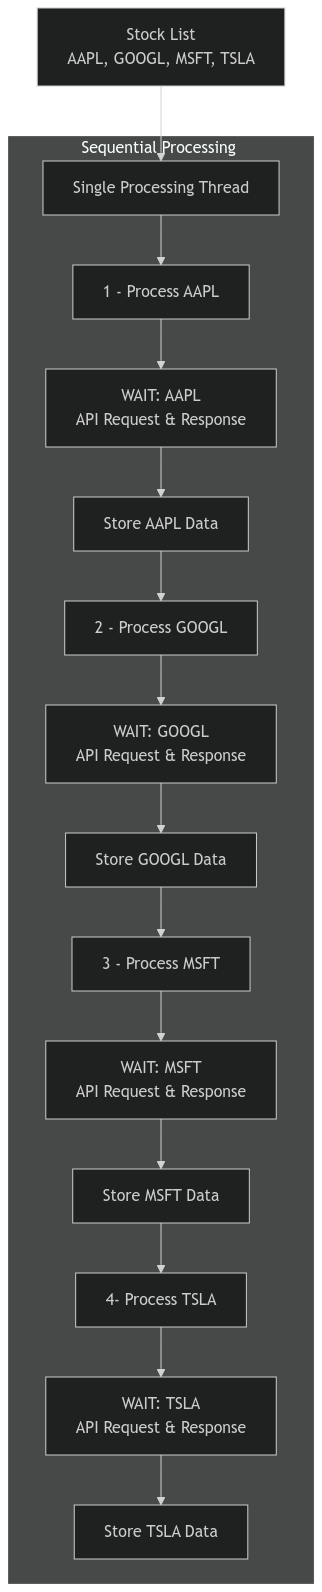

In [14]:
# Initialize tracking lists
successful_tickers = []
unsuccessful_tickers = []

# Load existing successful/unsuccessful tickers
try:
    with open('successful_tickers.txt', 'r') as f:
        successful_tickers = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(successful_tickers)} successful tickers")
except FileNotFoundError:
    print("No existing successful tickers file found")

try:
    with open('unsuccessful_tickers.txt', 'r') as f:
        unsuccessful_tickers = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(unsuccessful_tickers)} unsuccessful tickers")
except FileNotFoundError:
    print("No existing unsuccessful tickers file found")

Loaded 903 successful tickers
No existing unsuccessful tickers file found


Visual Representation of Parallel Processing

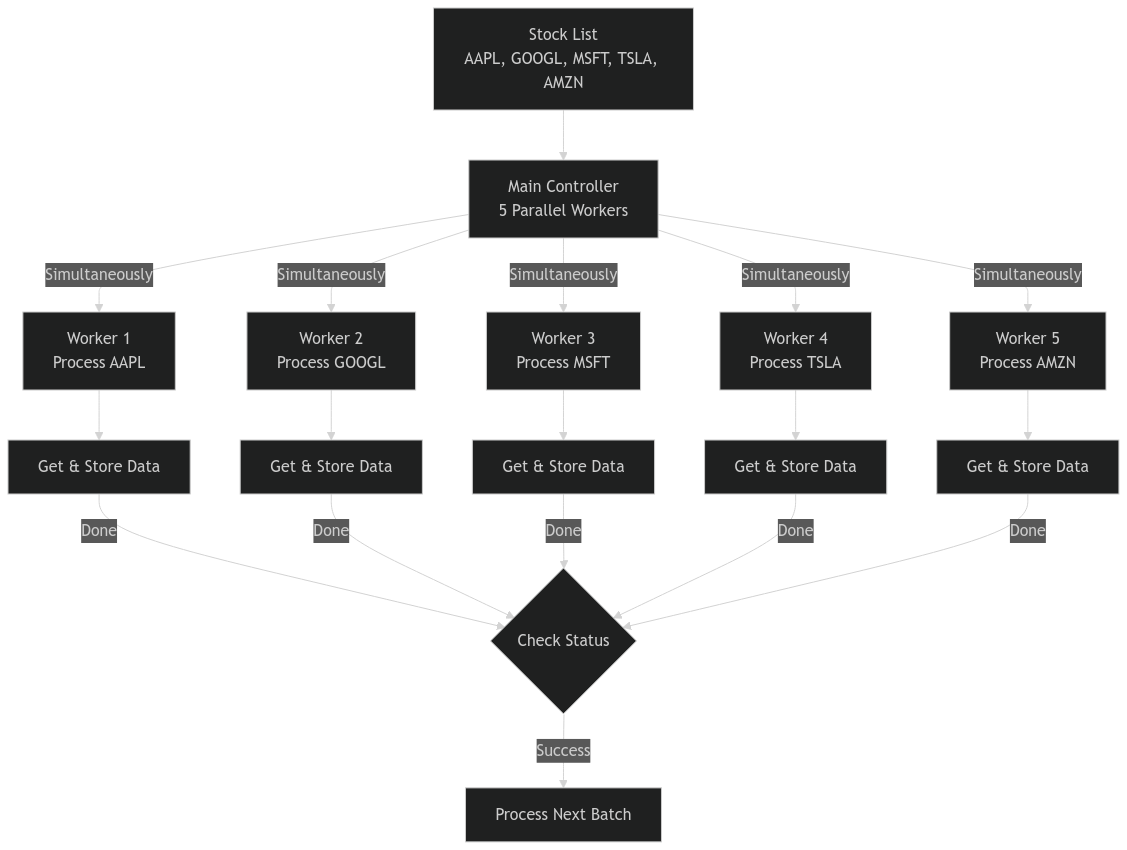

In [15]:
def process_stock(stock_ticker: str) -> str:
    # Skip if already processed
    if stock_ticker in successful_tickers:
        return f"Already processed {stock_ticker}"

    try:
        # Get and store stock data
        stock_data = get_stock_info(stock_ticker)
        stock_description = stock_data['Business Summary']

        # Store stock description in Pinecone
        vectorstore_from_texts = PineconeVectorStore.from_documents(
            documents=[Document(page_content=stock_description, metadata=stock_data)],
            embedding=hf_embeddings,
            index_name=index_name,
            namespace=namespace
        )

        # Track success
        with open('successful_tickers.txt', 'a') as f:
            f.write(f"{stock_ticker}\n")
        successful_tickers.append(stock_ticker)

        return f"Processed {stock_ticker} successfully"

    except Exception as e:
        # Track failure
        with open('unsuccessful_tickers.txt', 'a') as f:
            f.write(f"{stock_ticker}\n")
        unsuccessful_tickers.append(stock_ticker)

        return f"ERROR processing {stock_ticker}: {e}"

def parallel_process_stocks(tickers: list, max_workers: int = 10) -> None:
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_ticker = {
            executor.submit(process_stock, ticker): ticker
            for ticker in tickers
        }

        for future in concurrent.futures.as_completed(future_to_ticker):
            ticker = future_to_ticker[future]
            try:
                result = future.result()
                print(result)

                # Stop on error
                if result.startswith("ERROR"):
                    print(f"Stopping program due to error in {ticker}")
                    executor.shutdown(wait=False)
                    raise SystemExit(1)

            except Exception as exc:
                print(f'{ticker} generated an exception: {exc}')
                print("Stopping program due to exception")
                executor.shutdown(wait=False)
                raise SystemExit(1)

# Prepare your tickers
tickers_to_process = [company_tickers[num]['ticker'] for num in company_tickers.keys()]

# Process them
parallel_process_stocks(tickers_to_process, max_workers=10)

Already processed SW
Already processed FANG
Already processed ANET
Already processed EME
Already processed FITB
Already processed ALL
Already processed VRTX
Already processed BR
Already processed AER
Already processed ARES
Already processed FI
Already processed EJPRY
Already processed SNAP
Already processed DHI
Already processed RTNTF
Already processed PHM
Already processed AZO
Already processed ADP
Already processed EXPE
Already processed PNR
Already processed PSX
Already processed SNY
Already processed TROW
Already processed PTCAY
Already processed LMT
Already processed STLD
Already processed VRSN
Already processed CPRT
Already processed PANW
Already processed HAL
Already processed PCG
Already processed BSX
Already processed TSN
Already processed IEX
Already processed AMP
Already processed COP
Already processed AWK
Already processed NTES
Already processed C
Already processed PKG
Already processed ETR
Already processed URI
Already processed BHP
Already processed KEYS
Already processed

KeyboardInterrupt: 

### Perform RAG

In [16]:
# Initialize Pinecone
pc = Pinecone(api_key=userdata.get("PINECONE_API_KEY"),)

# Connect to your Pinecone index
pinecone_index = pc.Index(index_name)

In [17]:
query = "What are some comapnies that manufacture consumer hardware?"

In [18]:
raw_query_embedding = get_huggingface_embeddings(query)

In [19]:
top_matches = pinecone_index.query(vector = raw_query_embedding.tolist(), top_k=10, include_metadata=True, namespace=namespace)

In [20]:
top_matches

{'matches': [{'id': '74d21330-0251-49b9-b148-9cc03bafaf2d',
              'metadata': {'Business Summary': 'Avnet, Inc., distributes '
                                               'electronic component '
                                               'technology. The company '
                                               'operates through two segments, '
                                               'Electronic Components and '
                                               'Farnell. The Electronic '
                                               'Components segment markets, '
                                               'sells, and distributes '
                                               'semiconductors; interconnect, '
                                               'passive, and electromechanical '
                                               'components; and other '
                                               'integrated components from '
                            

In [21]:
contexts= [item['metadata']['text'] for item in top_matches['matches']]

In [22]:
augmented_query = "<CONTEXT>\n" + "\n\n-------\n\n".join(contexts[ : 10]) + "\n-------\n<CONTEXT>\n\n\n\nMY QUESTION:\n " + query

In [23]:
print(augmented_query)

<CONTEXT>
Avnet, Inc., distributes electronic component technology. The company operates through two segments, Electronic Components and Farnell. The Electronic Components segment markets, sells, and distributes semiconductors; interconnect, passive, and electromechanical components; and other integrated components from electronic component manufacturers. It also offers design chain support that provides engineers with technical design solutions; engineering and technical resources to support product design, bill of materials development, and technical education and training; and supply chain solutions that provide support, warehousing, and logistical services to original equipment manufacturers, electronic manufacturing service providers, and electronic component manufacturers. In addition, this segment provides embedded solutions, such as technical design, integration, and assembly of embedded products, systems, and solutions, as well as embedded display solutions comprising touch an

Format RAG Component with Groq

In [24]:
client = OpenAI(
  base_url="https://api.groq.com/openai/v1",
  api_key=userdata.get("GROQ_API_KEY")
  )

In [25]:
system_prompt = f""" You are a senior level financial advisor and an expert at providing answers and giving information about stocks.
Please answer my question below in a clear, detailed, and concise manner. Think about you answer step by step as you answer.
Format the answers with a numbered list of the most relavant stocks then another list with similar stocks to also look into"""

llm_response = client.chat.completions.create(
    model = "llama-3.1-70b-versatile",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": augmented_query}
    ]
)

response = llm_response.choices[0].message.content

In [26]:
print(response)

Based on the given context, here are some companies that manufacture consumer hardware:

**Most Relevant Stocks:**

1. **Asus (partially owned subsidiary of Pegatron and ASMedia subsidiaries of ASUS group)**: Manufactures desktop computers, laptops, mobile phones, gaming products, and motherboard components.
2. **HP Inc. (HPQ)**: Produces a wide range of consumer hardware, including desktops, laptops, printers, ink, and toners.
3. **Microsoft (MSFT)**: Manufactures Xbox gaming consoles, Surface tablets and laptops, and accessories like keyboards and mice.
4. **Samsung (partially owned subsidiary, Samsung Electronics Co Ltd: part of Samsung conglomerate)**: Produces consumer electronics such as smartphones, TVs, wearables, and home appliances.
5. **Lenovo (LNVGY)**: Manufactures a variety of consumer hardware products, including ThinkPad laptops, IdeaPad laptops, and ThinkCentre desktops.

**Similar Companies to Also Consider:**

1. **Dell Technologies (DELL)**: Produces desktop and lap

### Building the Front-End Chatbot

In [72]:
!pip install streamlit
!pip install pyngrok

In [114]:
%%writefile app.py

import streamlit as st
from langchain_pinecone import PineconeVectorStore
import openai
from openai import OpenAI
from google.colab import userdata
from langchain.schema import Document
from pinecone import Pinecone
from pyngrok import ngrok
from sentence_transformers import SentenceTransformer
import os

os.environ['GROQ_API_KEY'] = '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'

def get_huggingface_embeddings(text, model_name="sentence-transformers/all-mpnet-base-v2"):
    """
    Generates embeddings for the given text using a specified Hugging Face model.

    Args:
        text (str): The input text to generate embeddings for.
        model_name (str): The name of the Hugging Face model to use.
                          Defaults to "sentence-transformers/all-mpnet-base-v2".

    Returns:
        np.ndarray: The generated embeddings as a NumPy array.
    """
    model = SentenceTransformer(model_name)
    return model.encode(text)


# Initialize Pinecone
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"),)

# Connect to your Pinecone index
index_name = "stocks"
namespace = "stocks-descriptions"
pinecone_index = pc.Index(index_name)

# --- Streamlit App ---
st.title("AI Stock Finder Chatbot 🤖📈")
st.write("Welcome to your new personal AI Stock Finder. Enter below a sentance to query for stocks below. Enjoy!")
user_query = st.text_input("Enter your query to fins your stock:")

if st.button("Get Answer"):
    if user_query:
            # 1. Get embeddings and top matches from Pinecone
            raw_query_embedding = get_huggingface_embeddings(user_query)
            top_matches = pinecone_index.query(
                vector=raw_query_embedding.tolist(),
                top_k=10,
                include_metadata=True,
                namespace=namespace
            )
            contexts = [item['metadata']['text'] for item in top_matches['matches']]

            # 2. Create Augmented Query
            augmented_query = "<CONTEXT>\n" + "\n\n-------\n\n".join(contexts[:10]) + "\n-------\n<CONTEXT>\n\n\n\nMY QUESTION:\n " + user_query

            # 3. Query Groq LLM

            client = OpenAI(
              base_url="https://api.groq.com/openai/v1",
              api_key=os.environ.get('GROQ_API_KEY')
            )

            system_prompt = f"""You are a senior level financial advisor...""" # Your system prompt
            llm_response = client.chat.completions.create(
                model="llama-3.1-70b-versatile",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": augmented_query}
                ]
            )
            response = llm_response.choices[0].message.content

            # 4. Display the response
            st.write(response)



Overwriting app.py


In [89]:
# --- Run the app (for Google Colab) ---
!ngrok authtoken "2pbNIs8oUiF3QYz3qrStvIZhJ0u_2ojyL3N6r3Jg3A5UYvGoF" # Replace with your ngrok authtoken
public_url = ngrok.connect(addr=8501)
print(f"Your Streamlit app is running at: {public_url}")
!streamlit run app.py &>/dev/null&

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Your Streamlit app is running at: NgrokTunnel: "https://9d67-35-192-218-8.ngrok-free.app" -> "http://localhost:8501"


In [80]:
!pkill -f ngrok